In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
citations = pd.read_csv("data/citations.csv")
citations.head()

,source,target
0,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,09895f8b8e38dba2d62d742541778c97c91d97ce
1,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,0cb85c72ea11c067adbdf47e006cd51bd3065ea5
2,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,12463ae88245b865eaa11ef632132fb90d187a34
3,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,1f089bb17a848f6cf6d90da330352928cd6a4045
4,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,26ae952599aa9ba5815a80356024258247fc2b10


In [3]:
paper_data = pd.read_csv("data/paper_data.csv")
paper_data.embedding = paper_data.embedding.apply(eval).apply(np.array)
paper_data.head()

,paperId,title,embedding
0,b1cdd6b0ab88dd50b2d228854bd9de3512785444,Optimizing Energy Management Strategy and Degr...,"[-1.3419313430786133, 2.403834819793701, -3.24..."
1,e2316b446637ac8e7363af4a95e95b49e3178d97,Data driven quantitative trust model for the I...,"[-6.265685558319092, -2.0490870475769043, -2.8..."
2,b1e538dbf538fd9fdf5f5870c5b7416ae08c9882,Differentially Private Federated Learning: A C...,"[-5.616217613220215, -0.3546842336654663, -1.3..."
3,0300e96335922acbdee5b9ace2529c2c2c5726a9,Machine Recognition of Hand Printing,"[1.551882028579712, -4.45127010345459, -0.4198..."
4,6fc4c7a500a90bb23dbd33d3020338ea3f707019,Bayesian optimization for sensor set selection,"[-2.694502830505371, 0.4022102355957031, -1.16..."


In [4]:
og = citations.source[0]
og_embedding = paper_data.embedding[paper_data.paperId == og].values[0]

reference_embeddings = pd.merge(citations, paper_data, left_on="target", right_on="paperId")[["source", "embedding"]]
relevant = np.array(reference_embeddings.source == og)
embeddings = np.vstack(reference_embeddings.embedding.values)

print(relevant.shape)
print(embeddings.shape)

reference_embeddings

(3610,)
(3610, 768)


,source,embedding
0,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,"[-4.880043983459473, -4.219610214233398, -1.25..."
1,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,"[-0.6274266839027405, -2.1419906616210938, -0...."
2,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,"[1.1243658065795898, -4.05387020111084, 1.7792..."
3,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,"[-1.7022638320922852, -1.9811816215515137, 0.5..."
4,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,"[1.1668893098831177, -5.574405193328857, -2.45..."
...,...,...
3605,e767ea3f3875f096a70bbdac4847436a5e30800e,"[-3.1731231212615967, -2.318632125854492, -1.6..."
3606,e767ea3f3875f096a70bbdac4847436a5e30800e,"[-5.640353679656982, -6.740667343139648, 0.386..."
3607,e767ea3f3875f096a70bbdac4847436a5e30800e,"[-6.084494590759277, -5.140174865722656, -2.05..."
3608,e767ea3f3875f096a70bbdac4847436a5e30800e,"[-1.9880496263504028, -3.2681031227111816, -2...."


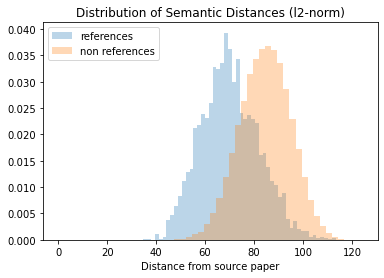

In [10]:
good = []
bad = []

for source_paper in np.unique(citations.source):
    source_embedding = paper_data.embedding[paper_data.paperId == source_paper].values[0]
    distances = np.linalg.norm(embeddings - source_embedding, axis=1)
    good.extend(distances[reference_embeddings.source == source_paper])
    bad.extend(distances[reference_embeddings.source != source_paper])

good = np.sort(np.array(good))
bad = np.sort(np.array(bad))

plt.hist(good, bins=50, alpha=0.3, label="references", density=True)
plt.hist(bad, bins=50, alpha=0.3, label="non references", density=True)
plt.xlabel("Distance from source paper")
plt.legend()
plt.title("Distribution of Semantic Distances (l2-norm)")
plt.show()

In [6]:
print(np.mean(good))
print(np.std(good))
print(np.mean(bad))
print(np.std(bad))
print(np.searchsorted(good, np.mean(bad))/len(good))

70.10626653742871
11.783035903742862
84.48931861850755
10.352484770216499
0.881163434903047


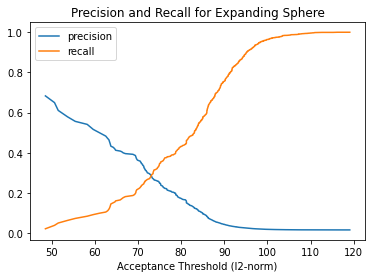

In [7]:
plt.figure(figsize=(6, 4))

precision_all = np.zeros([len(np.unique(citations.source)), len(distances)])
recall_all = np.zeros_like(precision_all)

for i, source_paper in enumerate(np.unique(citations.source)):
    source_embedding = paper_data.embedding[paper_data.paperId == source_paper].values[0]
    distances = np.linalg.norm(embeddings - source_embedding, axis=1)
    relevant_here = reference_embeddings.source == source_paper

    dist_sort = np.argsort(distances)
    relevant_sorted = relevant_here[dist_sort]

    precision = np.cumsum(relevant_sorted) / (np.arange(len(relevant_sorted)) + 1)
    recall = np.cumsum(relevant_sorted) / relevant_sorted.sum()

    precision_all[i, :] = precision
    recall_all[i, :] = recall

distances = distances[dist_sort]

plt.plot(distances, precision_all.mean(axis=0), label="precision")
plt.plot(distances, recall_all.mean(axis=0), label="recall")

plt.legend()
plt.title("Precision and Recall for Expanding Sphere")
plt.xlabel("Acceptance Threshold (l2-norm)")
plt.show()

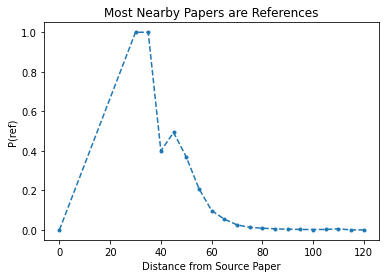

In [9]:
bin_width = 5
good_bins = pd.Series(good).groupby((good // bin_width)).count()
bad_bins = pd.Series(bad).groupby((bad // bin_width)).count()

df = pd.concat([good_bins, bad_bins], axis=1).fillna(0)
df.sort_index()
df["distance"] = df.index * bin_width
df["p_ref"] = df[0] / (df[0] + df[1])

idx = np.argsort(df.distance)
plt.plot(df.distance.values[idx], df.p_ref.values[idx], ".", linestyle="--")
plt.xlabel("Distance from Source Paper")
plt.ylabel("P(ref)")
plt.title("Most Nearby Papers are References")
plt.show()